In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import decoupler as dc
import ast
import functools
import neptune
import sys

In [2]:
working_dir = '/home/acollin/scPermut/'

In [3]:
import os
os.chdir(working_dir)

In [4]:
sys.path.append(working_dir)

In [5]:
from scpermut.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')


In [6]:
def load_run_df():
    project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

    runs_table_df = project.fetch_runs_table().to_pandas()
    project.stop()

    f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
    runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))
    return runs_table_df

In [7]:
from scpermut.workflow.dataset import load_dataset, Dataset
from scpermut.tools.utils import ann_subset, check_raw,save_json, load_json

/home/acollin/scPermut/analysis_notebooks


In [8]:
dataset_names = {'htap':'htap',
                "ajrccm_by_batch":"ajrccm_by_batch",
                'hlca_par_dataset_harmonized':'hlca_par_dataset_harmonized',
                'hlca_trac_dataset_harmonized':'hlca_trac_dataset_harmonized' ,
                'koenig_2022' : 'celltypist_dataset/koenig_2022/koenig_2022_healthy',
                'tosti_2021' : 'celltypist_dataset/tosti_2021/tosti_2021',
                'yoshida_2021' : 'celltypist_dataset/yoshida_2021/yoshida_2021',
                'tran_2021' : 'celltypist_dataset/tran_2021/tran_2021',
                'dominguez_2022_lymph' : 'celltypist_dataset/dominguez_2022/dominguez_2022_lymph',
                'dominguez_2022_spleen' : 'celltypist_dataset/dominguez_2022/dominguez_2022_spleen',
                'tabula_2022_spleen' : 'celltypist_dataset/tabula_2022/tabula_2022_spleen',
                'litvinukova_2020' : 'celltypist_dataset/litvinukova_2020/litvinukova_2020',
                 'lake_2021': 'celltypist_dataset/lake_2021/lake_2021'
                }


In [9]:
hp_list=['use_hvg',
'batch_size',
'clas_w',
'dann_w',
'rec_w',
'ae_bottleneck_activation',
         'clas_loss_name',
'size_factor',
'weight_decay',
'learning_rate',
'warmup_epoch',
'dropout',
'layer1',
'layer2',
'bottleneck',
        'training_scheme']
hp_list_numerical = ['use_hvg',
'batch_size',
'clas_w',
'dann_w',
'rec_w',
'weight_decay',
'learning_rate',
'warmup_epoch',
'dropout',
'layer1',
'layer2',
'bottleneck']

tracked_metric = 'val_balanced_mcc'

In [10]:
def load_confusion_matrix(neptune_id,train_split= 'val', working_dir = None):
    if working_dir :
        save_dir = working_dir + 'experiment_script/results/' + str(neptune_run_id) + '/'
    else :
        save_dir = './experiment_script/results/' + str(neptune_id) + '/'
    return pd.read_csv(save_dir + f'confusion_matrix_{train_split}.csv', index_col =0)

def load_pred(neptune_id, working_dir = None):
    if working_dir :
        save_dir = working_dir + 'experiment_script/results/' + str(neptune_id) + '/'
    else :
        save_dir = './experiment_script/results/' + str(neptune_id) + '/'
    return pd.read_csv(save_dir + f'predictions.csv', index_col =0).squeeze()


# Loading table

In [11]:
project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

runs_table_df = project.fetch_runs_table().to_pandas()
project.stop()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [12]:
runs_table_df

,sys/creation_time,sys/description,sys/failed,sys/hostname,sys/id,sys/modification_time,sys/monitoring_time,sys/name,sys/owner,sys/ping_time,...,monitoring/f8b5e678/tid,monitoring/febb37be/cpu,monitoring/febb37be/gpu,monitoring/febb37be/gpu_memory,monitoring/febb37be/hostname,monitoring/febb37be/memory,monitoring/febb37be/pid,monitoring/febb37be/stderr,monitoring/febb37be/stdout,monitoring/febb37be/tid
0,2024-02-23T09:24:03.297Z,,True,compute31,BEN-1,2024-03-08T10:42:14.617Z,75,Untitled,blaireaufurtif,2024-03-08T10:42:14.617Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-26T19:58:10.267Z,,True,compute30,BEN-1000,2024-03-18T17:15:22.762Z,999,Untitled,blaireaufurtif,2024-03-18T17:15:22.762Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-02-26T19:58:53.113Z,,False,compute31,BEN-1001,2024-03-18T17:15:27.744Z,1240,Untitled,blaireaufurtif,2024-03-18T17:15:27.744Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-02-26T20:00:29.803Z,,False,compute30,BEN-1002,2024-03-18T17:15:39.171Z,4881,Untitled,blaireaufurtif,2024-03-18T17:15:39.171Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-02-26T20:05:57.815Z,,False,compute30,BEN-1003,2024-03-18T17:15:45.819Z,494,Untitled,blaireaufurtif,2024-03-18T17:15:45.819Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6188,2024-03-20T09:18:33.812Z,,False,gpu03,BEN-7012,2024-03-20T09:33:26.285Z,893,Untitled,blaireaufurtif,2024-03-20T09:33:26.285Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6189,2024-03-20T09:26:33.469Z,,False,gpu01,BEN-7013,2024-03-20T09:33:30.087Z,417,Untitled,blaireaufurtif,2024-03-20T09:33:30.087Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6191,2024-03-20T09:43:33.097Z,,False,gpu01,BEN-7015,2024-03-20T09:53:21.22Z,588,Untitled,blaireaufurtif,2024-03-20T09:53:21.22Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6192,2024-03-20T09:50:57.851Z,,False,gpu01,BEN-7016,2024-03-20T09:53:18.699Z,141,Untitled,blaireaufurtif,2024-03-20T09:53:18.699Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))

In [2]:
# # adding trial number
# for dataset in hp_optim_df['dataset_name'].unique():
#     i=1
#     for run_id in hp_optim_df.query(f"dataset_name == '{dataset}'")['sys_id']:
#         run = neptune.init_run(project="becavin-lab/benchmark",
#                         api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
#                      with_id= run_id)
#         run['parameters/trial_count'] = i
#         run['parameters/total_trial'] = 50
#         run['parameters/hp_random_seed'] =  40
#         run.stop()
#         i+=1

In [9]:
run = neptune.init_run(project="becavin-lab/benchmark",
                        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
                     with_id= 'BEN-1')
run['parameters/debug_status'] = 'not_fixed'
print(run['parameters/debug_status'])
run.stop()

https://app.neptune.ai/becavin-lab/benchmark/e/BEN-1
<String field at "parameters/debug_status">
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/e/BEN-1/metadata


In [10]:
project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

runs_table_df = project.fetch_runs_table().to_pandas()
project.stop()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [10]:
runs_table_df

NameError: name 'runs_table_df' is not defined

## Checkpoint

In [8]:
project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

runs_table_df = project.fetch_runs_table().to_pandas()
project.stop()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [21]:
generic_r1 = load_json('/home/acollin/scPermut/experiment_script/hp_ranges/generic_r1.json')

In [23]:
[i['name'] for i in generic_r1]

['use_hvg',
 'batch_size',
 'clas_w',
 'rec_w',
 'dann_w',
 'ae_bottleneck_activation',
 'clas_loss_name',
 'size_factor',
 'learning_rate',
 'weight_decay',
 'warmup_epoch',
 'dropout',
 'bottleneck',
 'layer2',
 'layer1',
 'training_scheme']

In [24]:
generic_r1 = load_json('/home/acollin/scPermut/experiment_script/hp_ranges/generic_r1.json')
hp_list=[i['name'] for i in generic_r1]
hp_list_check = ['parameters_' + i for i in hp_list]

In [137]:
checkpoint_params = {k:i.iloc[0] for k,i in dict(runs_table_df[runs_table_df['sys_id'] == 'BEN-5210']).items() if k in ['dataset_name', 'opt_metric'] + hp_list}

In [133]:
{k:i.iloc[0] for k,i in dict(runs_table_df[runs_table_df['sys_id'] == 'BEN-5211']).items() if k in ['dataset_name', 'opt_metric'] + hp_list}

{'ae_bottleneck_activation': 'linear',
 'batch_size': 452.0,
 'bottleneck': 112.0,
 'clas_w': 0.050923253624466806,
 'dann_w': 0.00016806306472815982,
 'dataset_name': 'hlca_trac_dataset_harmonized',
 'dropout': 0.034085335209965706,
 'layer1': 711.0,
 'layer2': 240.0,
 'learning_rate': 0.0035616115353867698,
 'opt_metric': nan,
 'rec_w': 0.5045785838016709,
 'size_factor': 'raw',
 'use_hvg': 1921.0,
 'warmup_epoch': 32.0,
 'weight_decay': 6.46664431053696e-05}

In [134]:
checkpoint = runs_table_df[runs_table_df[list(checkpoint.keys())].eq(list(checkpoint.values())).all(axis=1)]

In [117]:
split, metric = 'val-balanced_mcc'.split('-')


In [152]:
checkpoint_params = {'use_hvg': 1279, 'batch_size': 169, 'clas_w': 0.04018853678085257, 'rec_w': 0.04102853294955443, 'dann_w': 0.014207088956669129, 'learning_rate': 0.0016615998978688155, 'weight_decay': 8.293518963142804e-05, 'warmup_epoch': 46, 'dropout': 0.22353026270866394, 'bottleneck': 125, 'layer2': 512, 'layer1': 1654, 'ae_bottleneck_activation': 'relu', 'size_factor': 'default'}



In [161]:
checkpoint_params = {'parameters/' + k: i for k,i in checkpoint_params.items()}
checkpoint_params['parameters/dataset_name'] = 'yoshida_2021'
checkpoint_params['parameters/opt_metric'] = 'val-balanced_mcc'


In [166]:
result = runs_table_df[runs_table_df[list(checkpoint_params.keys())].eq(list(checkpoint_params.values())).all(axis=1)]
split, metric =  'val-balanced_mcc'.split('-')
if result.empty or pd.isna(result.loc[:,f'evaluation/{split}/{metric}'].iloc[0]):
    print(result)

## TOP 10% average

In [77]:
def logarithmic_average(values):
    log_values = [math.log(x) for x in values]
    log_avg = sum(log_values) / len(log_values)
    original_avg = math.exp(log_avg)
    return original_avg


In [ ]:
aggregation_functions = {'dataset_name':lambda x: x.mode().iloc[0],
    tracked_metric: 'max',  # You may use 'max' or 'mean' depending on your requirement
    'use_hvg': 'mean',
    'batch_size': 'mean',
    'clas_w': logarithmic_average,
    'dann_w': logarithmic_average,
    'rec_w': logarithmic_average,
    'ae_bottleneck_activation': lambda x: x.mode().iloc[0],
    'size_factor':lambda x: x.mode().iloc[0],
    'weight_decay':logarithmic_average,
    'learning_rate':logarithmic_average,
    'warmup_epoch':'mean',
    'dropout':'mean',
    'layer1':'mean',
    'layer2':'mean',
    'bottleneck':'mean'
}
result_summary = top_10.agg(aggregation_functions)


std_functions = {'dataset_name':lambda x: x.mode().iloc[0],
    tracked_metric: 'max',  # You may use 'max' or 'mean' depending on your requirement
    'use_hvg': 'std',
    'batch_size': 'std',
    'clas_w': 'std',
    'dann_w': 'std',
    'rec_w': 'std',
    'ae_bottleneck_activation': lambda x: x.mode().iloc[0],
    'size_factor':lambda x: x.mode().iloc[0],
    'weight_decay':'std',
    'learning_rate':'std',
    'warmup_epoch':'std',
    'dropout':'std',
    'layer1':'std',
    'layer2':'std',
    'bottleneck':'std'}
std_summary = top_10.agg(std_functions)

In [ ]:
best = best[['dataset_name'] + hp_list]

In [ ]:
pd.concat([best_hp_df,best])

In [ ]:
best_hp_df.empty

# All at once

## TOP 10%

In [21]:
project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

runs_table_df = project.fetch_runs_table().to_pandas()
project.stop()

f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))

runs_table_df = runs_table_df.query("model == 'scPermut'").query("task == 'hp_optim'").query("opt_metric == 'val-balanced_mcc'")


https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [22]:
runs_table_df['dataset_name'].value_counts()

dominguez_2022_lymph            69
yoshida_2021                    68
dominguez_2022_spleen           67
tosti_2021                      65
koenig_2022                     60
tabula_2022_spleen              50
ajrccm_by_batch                 50
hlca_trac_dataset_harmonized    50
tran_2021                       50
htap                            49
lake_2021                       48
litvinukova_2020                42
hlca_par_dataset_harmonized     19
Name: dataset_name, dtype: int64

In [23]:
runs_table_df.loc[runs_table_df['dataset_name'] == 'hlca_par_dataset_harmonized',:]['trial_count']

4105     1.0
4127     2.0
4135     3.0
4168     4.0
4199     5.0
4211     6.0
4227     7.0
4234     8.0
4239     9.0
4241    10.0
4519    11.0
4531    12.0
4541    13.0
4585    14.0
4602    15.0
4631    16.0
4640    17.0
4780    18.0
5524    19.0
Name: trial_count, dtype: float64

In [24]:
sub = runs_table_df.query(f"dataset_name == 'yoshida_2021'").query("trial_count <= 50")


In [ ]:
# TOP 10% for each dataset
t10 = pd.DataFrame()
best_hp_df = pd.DataFrame(columns = ['dataset_name'] + hp_list)
for ds_name in dataset_names.keys():
    sub = runs_table_df.query(f"dataset_name == '{ds_name}'")
    if not sub.empty:
        top_10 = sub[sub[tracked_metric] >= sub[tracked_metric].quantile(0.9)]
        aggregation_functions = {'dataset_name':lambda x: x.mode().iloc[0],
            tracked_metric: 'max',  # You may use 'max' or 'mean' depending on your requirement
            'use_hvg': 'mean',
            'batch_size': 'mean',
            'clas_w': logarithmic_average,
            'dann_w': logarithmic_average,
            'rec_w': logarithmic_average,
            'ae_bottleneck_activation': lambda x: x.mode().iloc[0],
            'size_factor':lambda x: x.mode().iloc[0],
            'weight_decay':logarithmic_average,
            'learning_rate':logarithmic_average,
            'warmup_epoch':'mean',
            'dropout':'mean',
            'layer1':'mean',
            'layer2':'mean',
            'bottleneck':'mean'
        }
        result_summary = pd.DataFrame(top_10.agg(aggregation_functions)).transpose()
        best_hp_df = pd.concat([best_hp_df,result_summary])
        best_hp_df.index = best_hp_df['dataset_name'].values
        t10 = pd.concat([t10, top_10])

In [45]:
best_hp_df = pd.DataFrame(columns = ['dataset_name'] + hp_list)

for ds_name in dataset_names.keys():
    sub = runs_table_df.query(f"dataset_name == '{ds_name}'").query("trial_count <= 50")
    if not sub.empty:
        best = sub[sub[tracked_metric] == sub[tracked_metric].max()][['dataset_name', 'sys_id', tracked_metric] + hp_list]
        best['best_trial'] = sub.loc[sub[tracked_metric] == sub[tracked_metric].max(), :].loc[:,'trial_count'].values[0]#   np.where(sub == sub[tracked_metric].max())[0][0]
        best_hp_df = pd.concat([best_hp_df,best])
        best_hp_df.index = best_hp_df['dataset_name'].values

In [50]:
best_hp_df[int_columns] = best_hp_df[int_columns].astype(int)

In [53]:
best_hp_df.to_csv(working_dir + 'experiment_script/benchmark/best_hp.csv')

## Best

In [11]:
runs_table_df = load_run_df()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [14]:
runs_table_df = runs_table_df.query("model == 'scPermut'").query("task == 'hp_optim_V2'").query("opt_metric == 'val-balanced_mcc'")
runs_table_df['dataset_name'].value_counts()

tosti_2021                      112
dominguez_2022_spleen           106
tran_2021                       100
hlca_trac_dataset_harmonized     85
htap                             83
koenig_2022                      81
lake_2021                        77
dominguez_2022_lymph             65
ajrccm_by_batch                  65
yoshida_2021                     60
tabula_2022_spleen               55
litvinukova_2020                 50
hlca_par_dataset_harmonized      38
Name: dataset_name, dtype: int64

In [15]:
runs_table_df.groupby('dataset_name')['trial_count'].max()

dataset_name
ajrccm_by_batch                 45.0
dominguez_2022_lymph            46.0
dominguez_2022_spleen           50.0
hlca_par_dataset_harmonized     30.0
hlca_trac_dataset_harmonized    42.0
htap                            46.0
koenig_2022                     50.0
lake_2021                       50.0
litvinukova_2020                38.0
tabula_2022_spleen              50.0
tosti_2021                      49.0
tran_2021                       50.0
yoshida_2021                    47.0
Name: trial_count, dtype: float64

In [14]:
runs_table_df

,sys_creation_time,sys_description,sys_failed,sys_hostname,sys_id,sys_modification_time,sys_monitoring_time,sys_name,sys_owner,sys_ping_time,...,monitoring_ff237c90_tid,monitoring_ffb5af3e_cpu,monitoring_ffb5af3e_gpu,monitoring_ffb5af3e_gpu_memory,monitoring_ffb5af3e_hostname,monitoring_ffb5af3e_memory,monitoring_ffb5af3e_pid,monitoring_ffb5af3e_stderr,monitoring_ffb5af3e_stdout,monitoring_ffb5af3e_tid
6050,2024-03-20T13:10:24.597Z,,False,gpu01,BEN-7033,2024-03-20T13:20:08.172Z,584,Untitled,blaireaufurtif,2024-03-20T13:20:08.172Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6051,2024-03-20T13:10:24.605Z,,False,gpu01,BEN-7034,2024-03-20T13:34:01.848Z,1417,Untitled,blaireaufurtif,2024-03-20T13:34:01.848Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6052,2024-03-20T13:20:08.525Z,,False,gpu01,BEN-7035,2024-03-20T13:30:07.942Z,599,Untitled,blaireaufurtif,2024-03-20T13:30:07.942Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6053,2024-03-20T13:30:08.299Z,,False,gpu01,BEN-7036,2024-03-20T13:41:52.795Z,705,Untitled,blaireaufurtif,2024-03-20T13:41:52.795Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6054,2024-03-20T13:34:02.414Z,,False,gpu01,BEN-7037,2024-03-20T14:06:43.594Z,1961,Untitled,blaireaufurtif,2024-03-20T14:06:43.594Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,2024-04-22T17:47:02.244Z,,False,gpu03,BEN-9146,2024-04-22T21:49:08.428Z,14526,Untitled,blaireaufurtif,2024-04-22T21:49:08.428Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8315,2024-04-22T21:49:09.317Z,,False,gpu03,BEN-9168,2024-04-23T03:21:02.468Z,19912,Untitled,blaireaufurtif,2024-04-23T03:21:02.468Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8346,2024-04-23T03:21:02.978Z,,False,gpu03,BEN-9196,2024-04-23T06:53:25.078Z,12742,Untitled,blaireaufurtif,2024-04-23T06:53:25.078Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8368,2024-04-23T06:53:25.592Z,,False,gpu03,BEN-9216,2024-04-23T11:43:58.676Z,17432,Untitled,blaireaufurtif,2024-04-23T11:43:58.676Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
hlca_par_dataset_harmonized
litvinukova_2020

NameError: name 'hlca_par_dataset_harmonized' is not defined

In [16]:
hp_list=['use_hvg',
'batch_size',
'clas_w',
'dann_w',
'rec_w',
'ae_bottleneck_activation',
         'clas_loss_name',
'size_factor',
'weight_decay',
'learning_rate',
'warmup_epoch',
'dropout',
'layer1',
'layer2',
'bottleneck',
        'training_scheme']

In [17]:


check_list = ['dataset_name',
    'task',
'total_trial',
'hp_random_seed',
'trial_count',
'opt_metric']

In [18]:
runs_table_df.query('dataset_name == "tosti_2021"')[hp_list + check_list].query('trial_count == 2')

,use_hvg,batch_size,clas_w,dann_w,rec_w,ae_bottleneck_activation,clas_loss_name,size_factor,weight_decay,learning_rate,...,layer1,layer2,bottleneck,training_scheme,dataset_name,task,total_trial,hp_random_seed,trial_count,opt_metric
6276,4643.0,512,2.006568,0.374187,0.141548,linear,categorical_focal_crossentropy,default,0.000043,0.000254,...,614,286,62,training_scheme_8,tosti_2021,hp_optim_V2,50.0,40.0,2.0,val-balanced_mcc
6468,4643.0,512,2.006568,0.374187,0.141548,linear,categorical_focal_crossentropy,default,0.000043,0.000254,...,614,286,62,training_scheme_8,tosti_2021,hp_optim_V2,50.0,40.0,2.0,val-balanced_mcc
6693,4643.0,512,2.006568,0.374187,0.141548,linear,categorical_focal_crossentropy,default,0.000043,0.000254,...,614,286,62,training_scheme_8,tosti_2021,hp_optim_V2,50.0,40.0,2.0,val-balanced_mcc
6790,4643.0,512,2.006568,0.374187,0.141548,linear,categorical_focal_crossentropy,default,0.000043,0.000254,...,614,286,62,training_scheme_8,tosti_2021,hp_optim_V2,50.0,40.0,2.0,val-balanced_mcc


In [19]:
checkpoint = {k:v for k,v in zip(runs_table_df.query('dataset_name == "tosti_2021"')[hp_list + check_list].query('trial_count == 2').iloc[0].index, runs_table_df.query('dataset_name == "tosti_2021"')[hp_list + check_list].query('trial_count == 2').iloc[0].values)}

In [20]:
result = runs_table_df[runs_table_df[list(checkpoint.keys())].eq(list(checkpoint.values())).all(axis=1)]

In [19]:
opt_metric = 'val-balanced_mcc'
split, metric = opt_metric.split('-')

In [20]:
best_hp_df = pd.DataFrame(columns = ['dataset_name'] + hp_list)
for ds_name in dataset_names.keys():
    sub = runs_table_df.query(f"dataset_name == '{ds_name}'")
    if not sub.empty:
        result_summary = sub.loc[sub[tracked_metric] == sub[tracked_metric].max(),:].loc[:,['dataset_name', 'sys_id'] + hp_list]
        best_hp_df = pd.concat([best_hp_df,result_summary])
        best_hp_df.index = best_hp_df['dataset_name'].values

In [21]:
best_hp_df['use_hvg'] = best_hp_df['use_hvg'].convert_dtypes(int)
best_hp_df['warmup_epoch'] = best_hp_df['warmup_epoch'].convert_dtypes(int)
best_hp_df['layer1'] = best_hp_df['layer1'].convert_dtypes(int)
best_hp_df['layer2'] = best_hp_df['layer2'].convert_dtypes(int)
best_hp_df['bottleneck'] = best_hp_df['bottleneck'].convert_dtypes(int)
best_hp_df['batch_size'] = best_hp_df['batch_size'].convert_dtypes(int)


In [22]:
best_hp_df.to_csv(working_dir + 'experiment_script/benchmark/best_hp.csv')

In [37]:
best_hp_df = pd.DataFrame(columns = ['dataset_name'] + hp_list)
for ds_name in dataset_names.keys():
    sub = runs_table_df.query(f"dataset_name == '{ds_name}'").query('training_scheme == "training_scheme_8"')
    if not sub.empty:
        result_summary = sub.loc[sub[tracked_metric] == sub[tracked_metric].max(),:].loc[:,['dataset_name', 'sys_id'] + hp_list]
        best_hp_df = pd.concat([best_hp_df,result_summary])
        best_hp_df.index = best_hp_df['dataset_name'].values

best_hp_df['use_hvg'] = best_hp_df['use_hvg'].convert_dtypes(int)
best_hp_df['warmup_epoch'] = best_hp_df['warmup_epoch'].convert_dtypes(int)
best_hp_df['layer1'] = best_hp_df['layer1'].convert_dtypes(int)
best_hp_df['layer2'] = best_hp_df['layer2'].convert_dtypes(int)
best_hp_df['bottleneck'] = best_hp_df['bottleneck'].convert_dtypes(int)
best_hp_df['batch_size'] = best_hp_df['batch_size'].convert_dtypes(int)


In [38]:
best_hp_df.to_csv(working_dir + 'experiment_script/benchmark/best_hp_scheme_8.csv')

In [33]:
best_hp_df['training_scheme'] = 'training_scheme_9'

In [34]:
best_hp_df.to_csv(working_dir + 'experiment_script/benchmark/best_hp_scheme_9.csv')

# HP exploration - determining default setup

In [34]:
complexity_df = pd.read_csv(working_dir + 'experiment_script/benchmark/complexity_df.csv', index_col = 0)

In [27]:
from scpermut.workflow.dataset import load_dataset

dataset_names = {'htap':'htap',
                "ajrccm_by_batch":"ajrccm_by_batch",
                'hlca_par_dataset_harmonized':'hlca_par_dataset_harmonized',
                'hlca_trac_dataset_harmonized':'hlca_trac_dataset_harmonized' ,
                'koenig_2022' : 'celltypist_dataset/koenig_2022/koenig_2022_healthy',
                'tosti_2021' : 'celltypist_dataset/tosti_2021/tosti_2021',
                'yoshida_2021' : 'celltypist_dataset/yoshida_2021/yoshida_2021',
                'tran_2021' : 'celltypist_dataset/tran_2021/tran_2021',
                'dominguez_2022_lymph' : 'celltypist_dataset/dominguez_2022/dominguez_2022_lymph',
                'dominguez_2022_spleen' : 'celltypist_dataset/dominguez_2022/dominguez_2022_spleen',
                'tabula_2022_spleen' : 'celltypist_dataset/tabula_2022/tabula_2022_spleen',
                'litvinukova_2020' : 'celltypist_dataset/litvinukova_2020/litvinukova_2020',
                 'lake_2021': 'celltypist_dataset/lake_2021/lake_2021'
                }

diff_dict = {'homo': ['tosti_2021', 'tran_2021', 'yoshida_2021', 'htap', 'ajrccm_by_batch'],
           'assays': ['dominguez_2022_lymph', 'dominguez_2022_spleen', 'tabula_2022_spleen'],
           'suspension': ['koenig_2022', 'litvinukova_2020', 'lake_2021'],
           'datasets': ['hlca_par_dataset_harmonized','hlca_trac_dataset_harmonized']}

In [ ]:
adatas = {name:load_dataset(name, working_dir+ 'data') for name in dataset_names}

n_cells = {n : ad.n_obs for n, ad in adatas.items()}
best_hp_df['n_cells'] = best_hp_df['dataset_name'].replace(n_cells)
best_hp_df.to_csv(working_dir + 'experiment_script/benchmark/best_hp_w_ncells.csv')

In [66]:
# TOP 10% for each dataset
t10 = pd.DataFrame()
best_hp_df = pd.DataFrame(columns = ['dataset_name'] + hp_list)
for ds_name in dataset_names.keys():
    sub = runs_table_df.query(f"dataset_name == '{ds_name}'")
    if not sub.empty:
        top_10 = sub[sub[tracked_metric] >= sub[tracked_metric].quantile(0.9)]
        t10 = pd.concat([t10, top_10])

In [67]:
complexity_df

,dataset,complexity,n_cells,n_celltypes
0,htap,0.820225,72583,47
1,ajrccm_by_batch,0.807658,77969,28
2,hlca_par_dataset_harmonized,0.911493,330199,37
3,hlca_trac_dataset_harmonized,0.923365,137922,16
4,koenig_2022,0.953405,150582,14
5,tosti_2021,0.813652,79367,14
6,yoshida_2021,0.950520,46964,34
7,tran_2021,0.878815,10067,14
8,dominguez_2022_lymph,0.942871,82974,35
9,dominguez_2022_spleen,0.938454,70099,38


In [68]:
t10 = t10.merge(complexity_df, left_on = 'dataset_name', right_on = 'dataset')
best_hp_df = best_hp_df.merge(complexity_df, left_on = 'dataset_name', right_on = 'dataset')

In [ ]:
t10['n_cells'] = t10['n_cells_x']

In [ ]:
n_plots

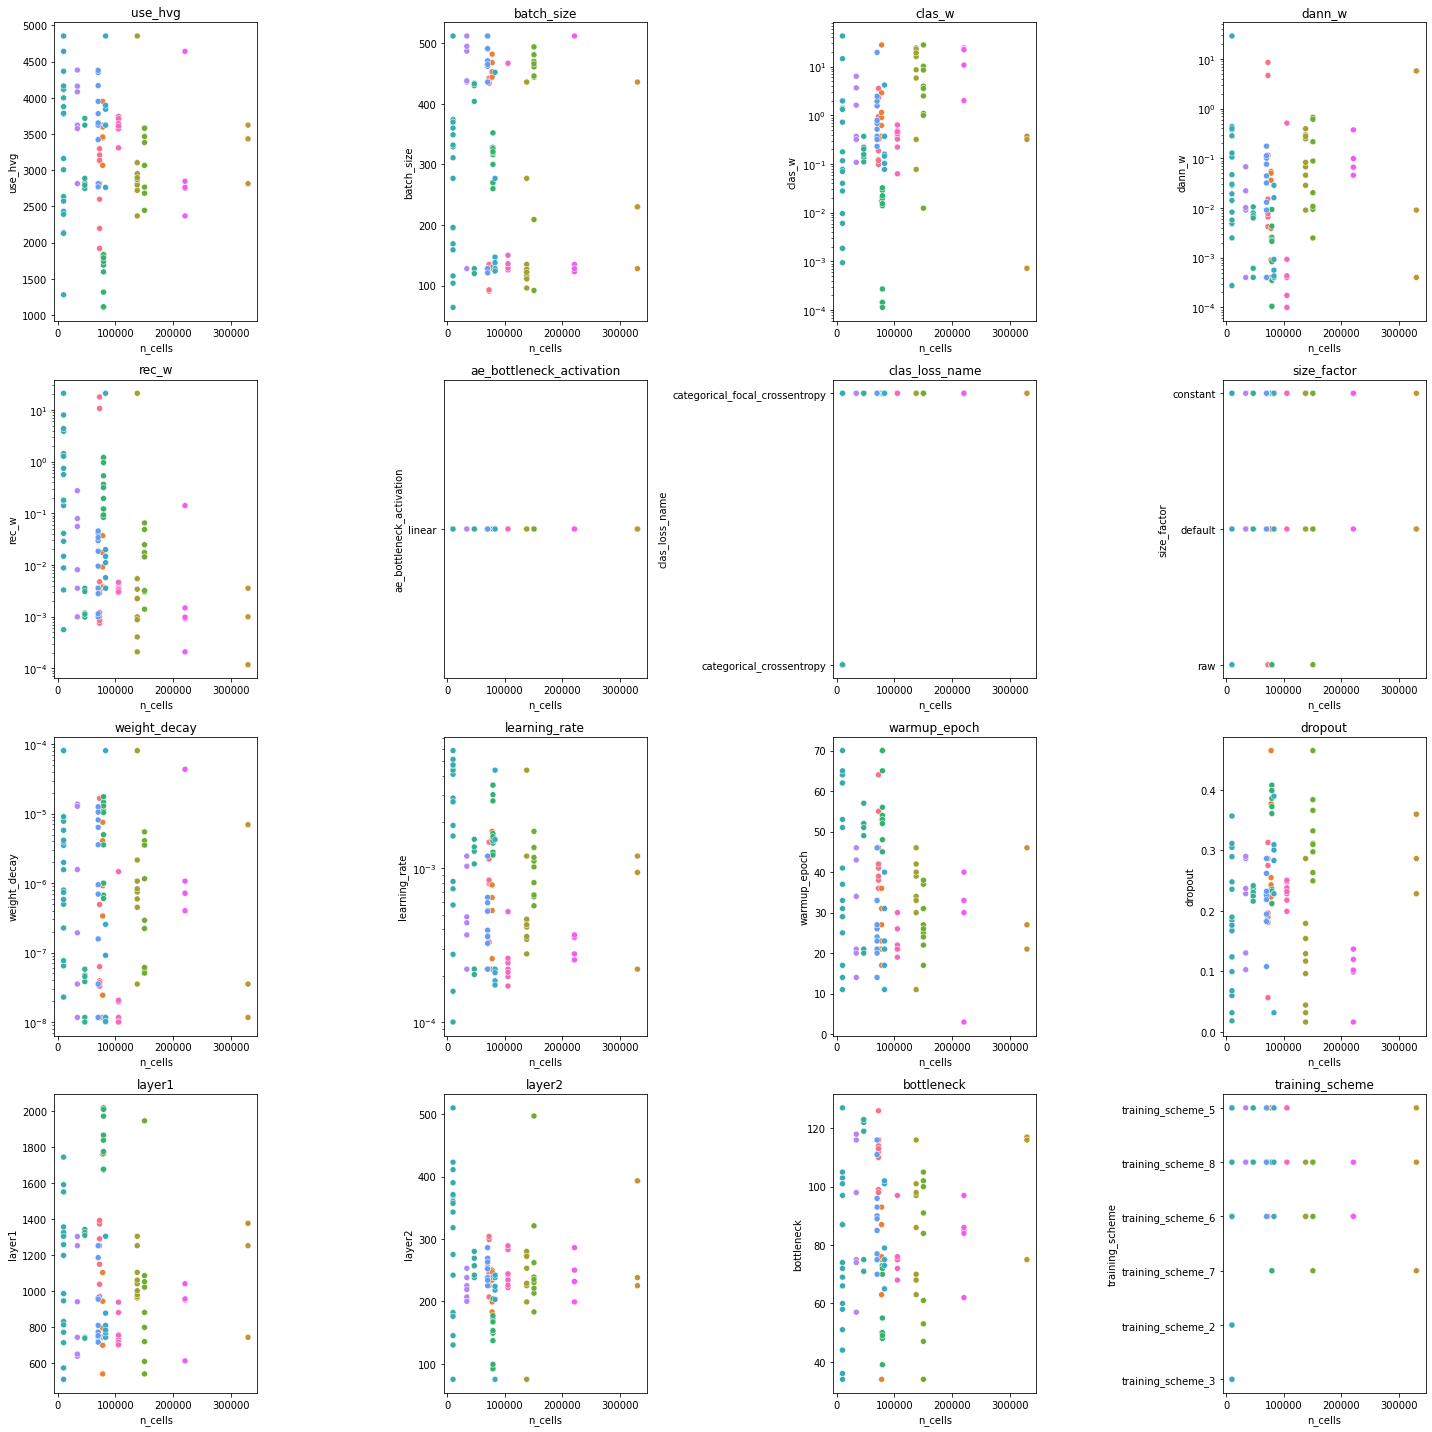

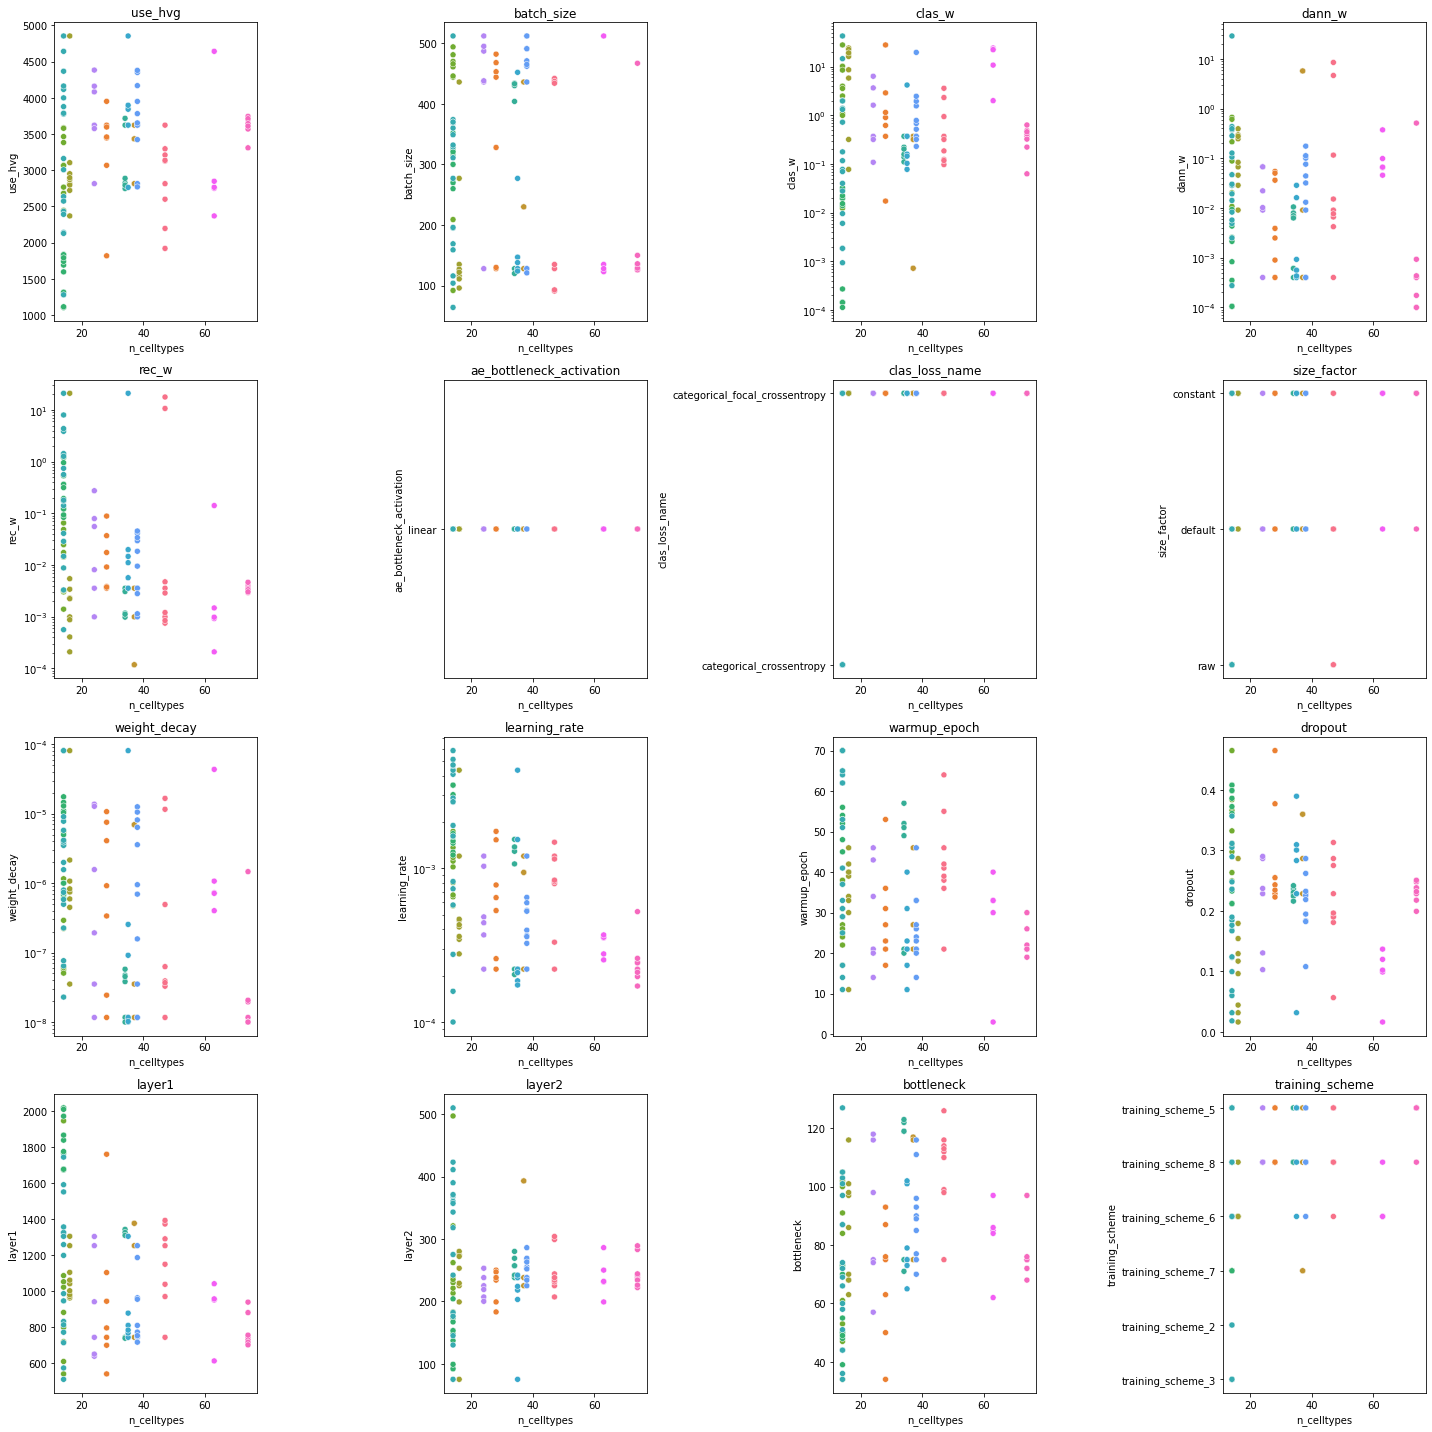

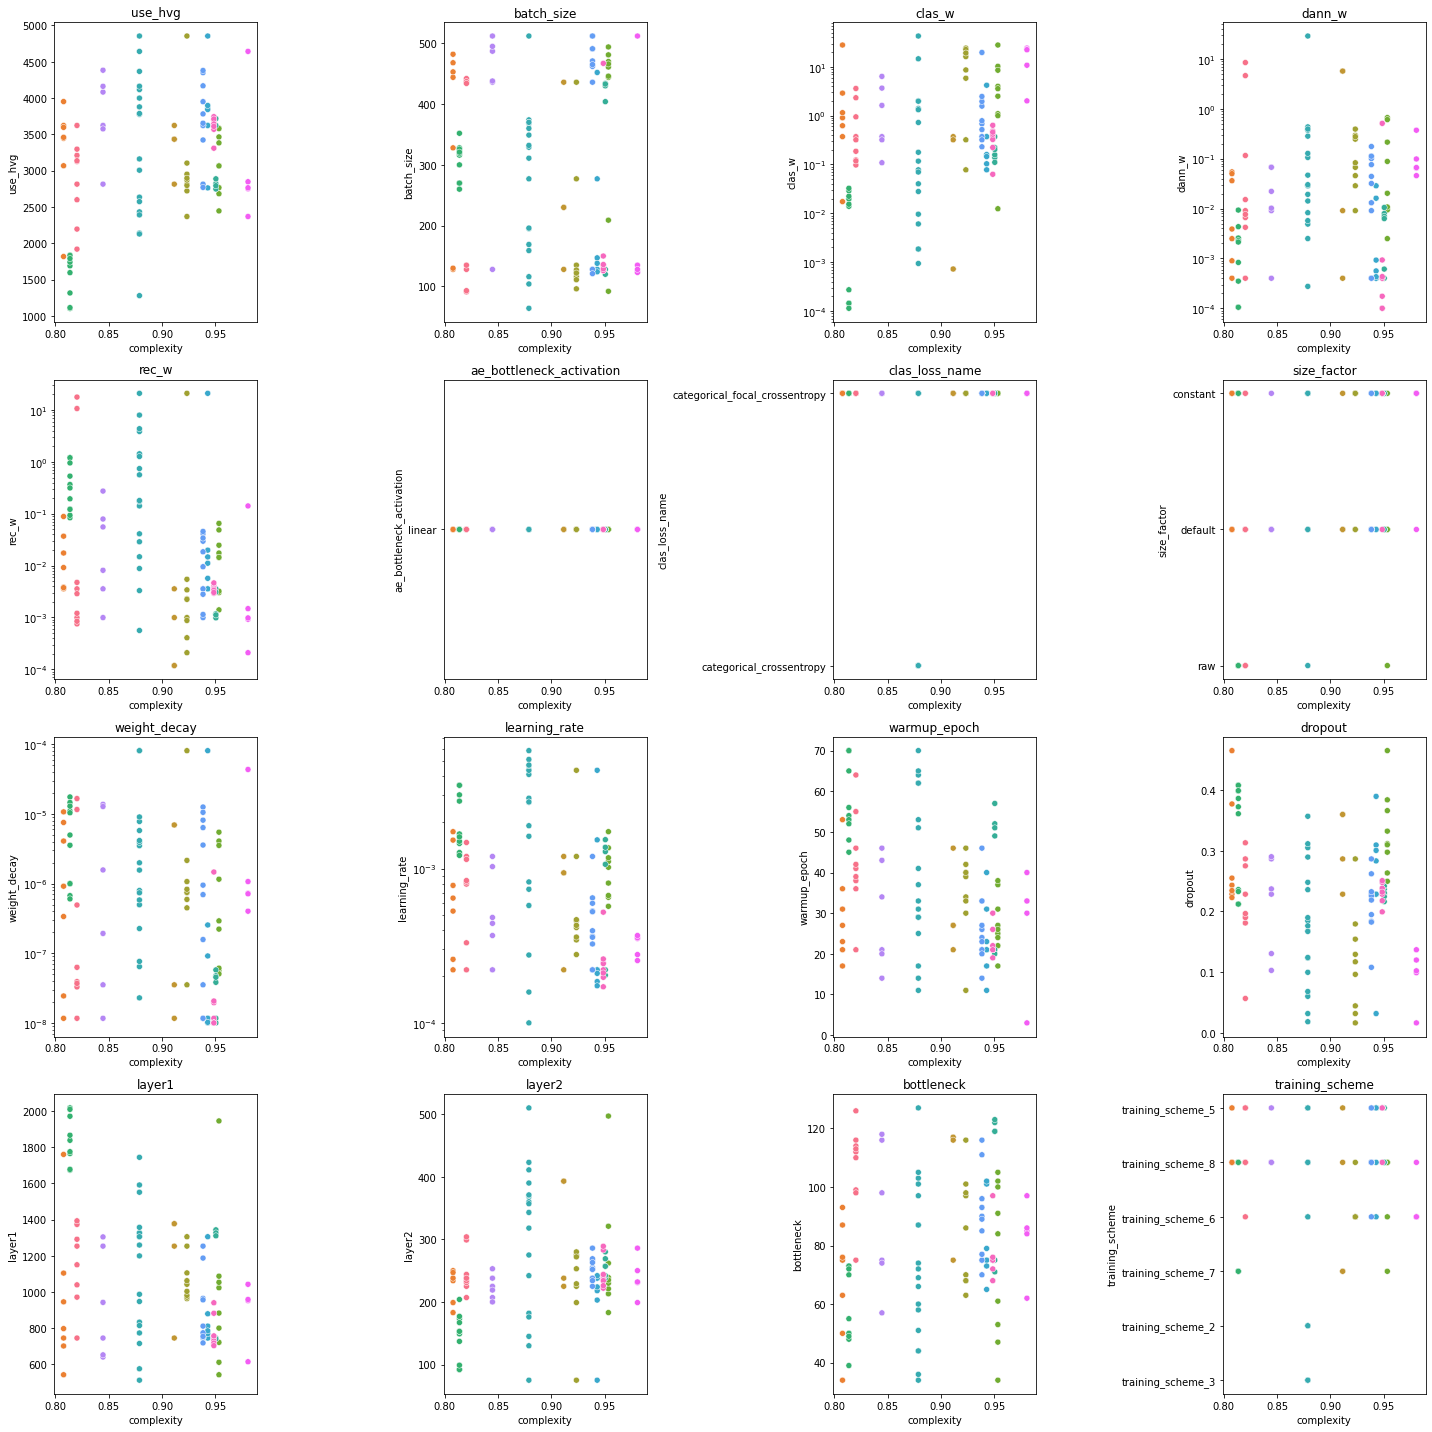

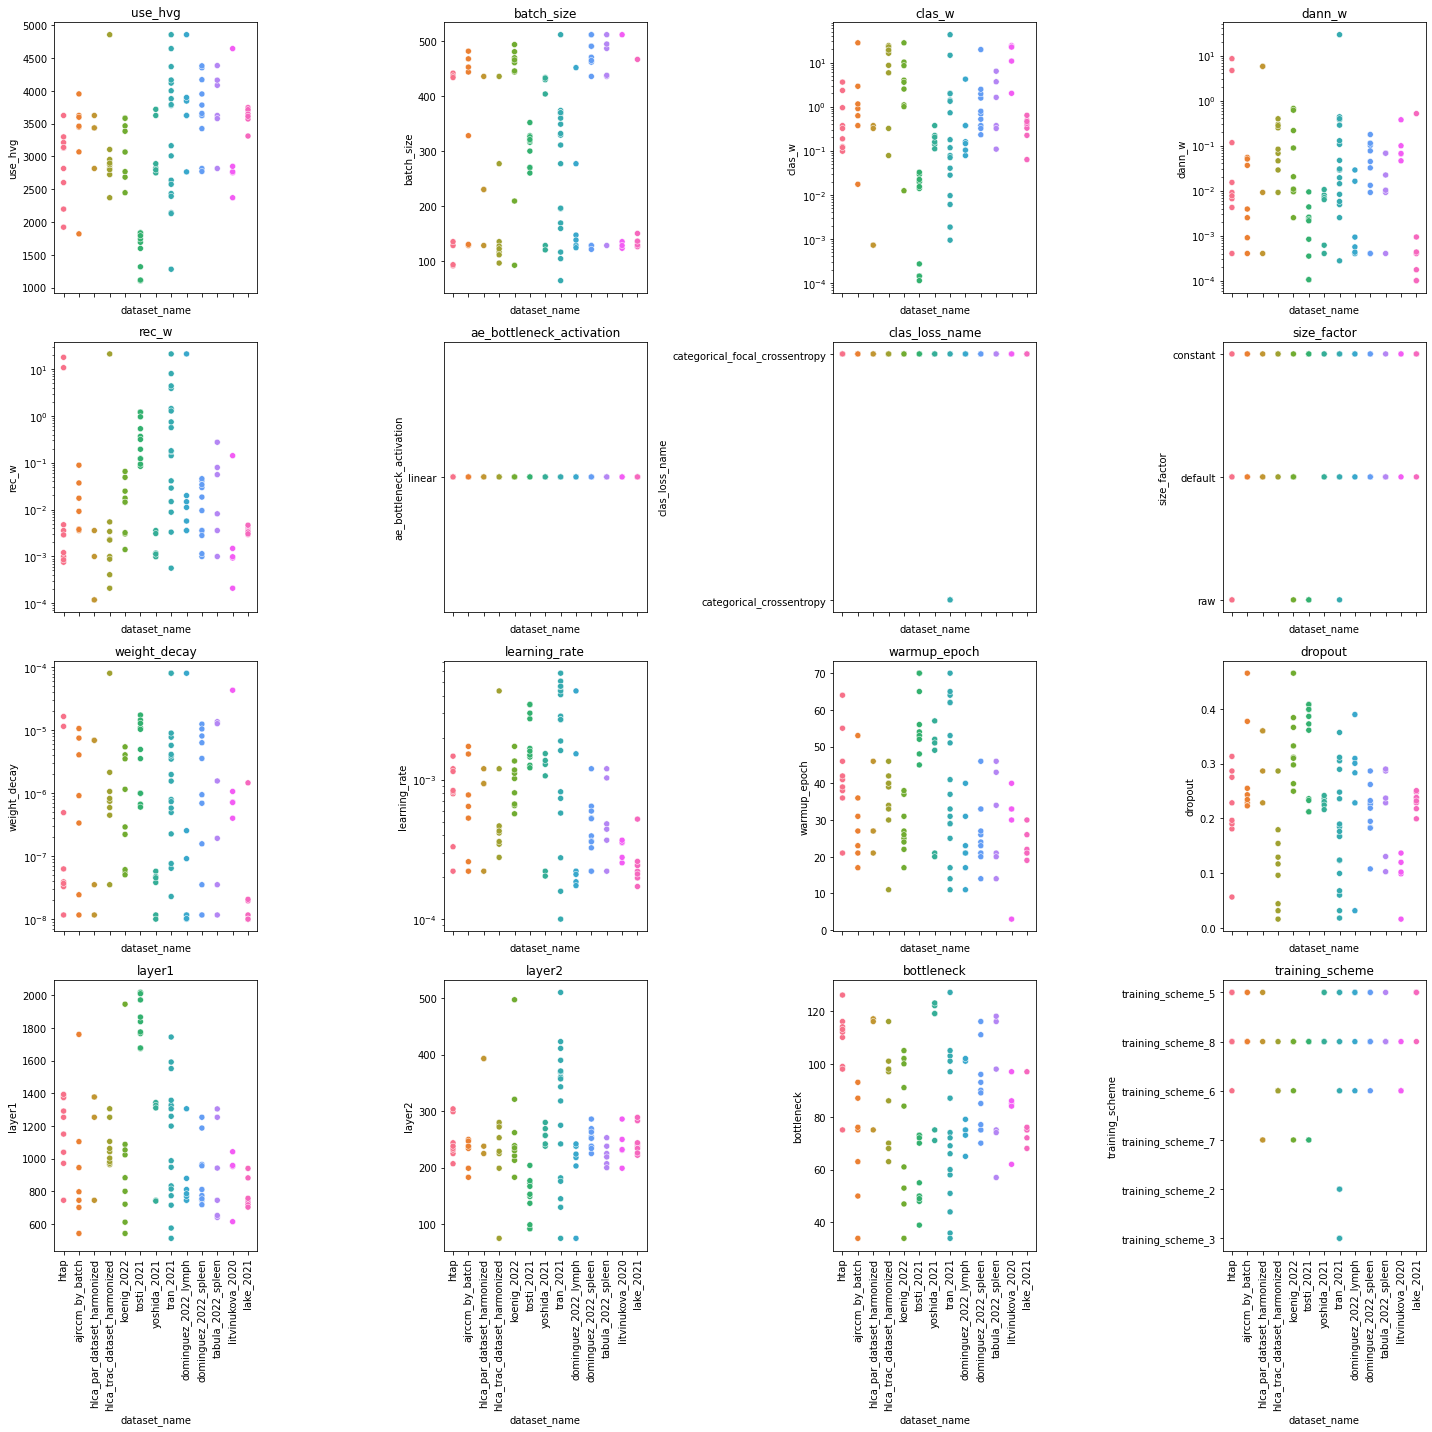

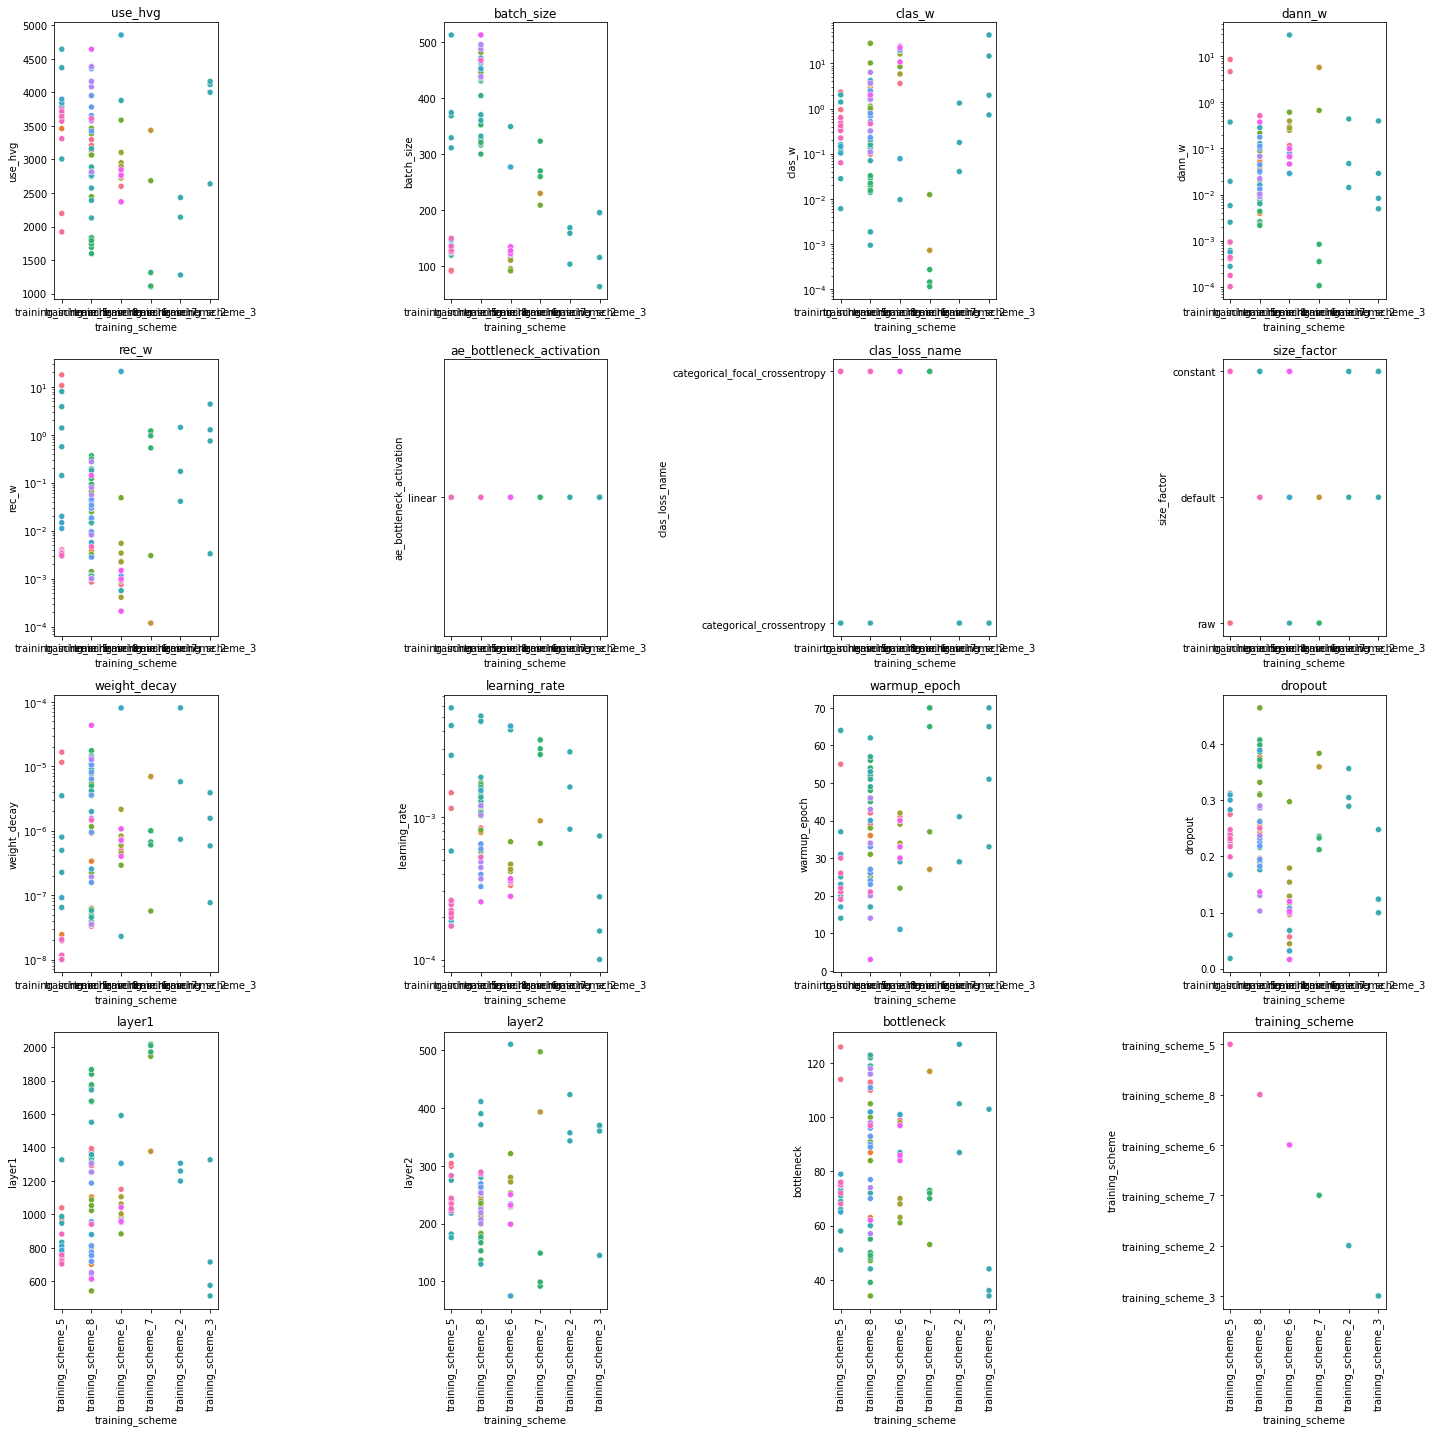

In [74]:
import math
n_plots = len(hp_list)
n_col = 4
n_row = math.ceil(n_plots/n_col)
# to_plot  = t10.loc[t10['training_scheme'] == 'training_scheme_8']
to_plot = t10

x = 'n_cells'
for x in ['n_cells', 'n_celltypes','complexity', 'dataset_name' , 'training_scheme']:
    f, axes = plt.subplots(n_row,n_col, figsize = (20,20))
    i = 0
    for met in hp_list:
        r = i // n_col
        c = i % n_col
        ax = axes[r,c]
        sns.scatterplot(to_plot, x=  x, y= met, hue = 'dataset_name',ax = axes[r,c] , legend = False)

        if met in ['clas_w', 'dann_w', 'rec_w', 'weight_decay', 'learning_rate']:
            ax.set_yscale('log')
        if x in ['dataset_name', 'training_scheme'] and r == n_row-1:
            ax.tick_params(axis='x', rotation=90)
        elif x != 'dataset_name':
            pass
        else :
            ax.set_xticklabels('')
        ax.set_title(met)
        # ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        i+=1
        plt.tight_layout()

In [ ]:
import math
n_plots = len(hp_list)
n_col = 4
n_row = math.ceil(n_plots/n_col)
to_plot  = t10.loc[t10['training_scheme'] == 'training_scheme_8']
#to_plot = t10

x = 'n_cells'
for x in ['n_cells', 'n_celltypes','complexity', 'dataset_name']:
    f, axes = plt.subplots(n_row,n_col, figsize = (20,20))
    i = 0
    for met in hp_list:
        r = i // n_col
        c = i % n_col
        ax = axes[r,c]
        sns.scatterplot(to_plot, x=  x, y= met, hue = 'dataset_name',ax = axes[r,c] , legend = False)

        if met in ['clas_w', 'dann_w', 'rec_w', 'weight_decay', 'learning_rate']:
            ax.set_yscale('log')
        if x == 'dataset_name' and r == n_row-1:
            ax.tick_params(axis='x', rotation=90)
        elif x != 'dataset_name':
            pass
        else :
            ax.set_xticklabels('')
        ax.set_title(met)
        # ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        i+=1
        plt.tight_layout()

In [ ]:

x = 'n_cells'
for x in ['n_cells', 'n_celltypes','complexity', 'dataset_name']:
    f, axes = plt.subplots(n_row,n_col, figsize = (20,20))
    i = 0
    for met in hp_list:
        r = i // 3
        c = i % 3
        ax = axes[r,c]
        sns.scatterplot(t10, x=  x, y= met, hue = 'dataset_name',ax = axes[r,c] , legend = False)

        if met in ['clas_w', 'dann_w', 'rec_w', 'weight_decay', 'learning_rate']:
            ax.set_yscale('log')
        if x == 'dataset_name' and r == n_row-1:
            ax.tick_params(axis='x', rotation=90)
        elif x != 'dataset_name':
            pass
        else :
            ax.set_xticklabels('')
        ax.set_title(met)
        # ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        i+=1
        plt.tight_layout()

In [212]:
default_config

,use_hvg,batch_size,clas_w,dann_w,rec_w,ae_bottleneck_activation,size_factor,weight_decay,learning_rate,warmup_epoch,dropout,layer1,layer2,bottleneck
0,3471.338462,374.123077,0.067567,0.003239,2.877708,linear,constant,0.000003,0.00124,50.446154,0.084533,1576.938462,302.907692,89.969231


In [86]:
t10_scheme_8 = t10[t10['training_scheme'] == 'training_scheme_8']
best_hp_df_scheme_8 = best_hp_df[best_hp_df['training_scheme'] == 'training_scheme_8']
aggregation_functions = {
            'use_hvg': 'mean',
            'batch_size': 'mean',
            'clas_w': logarithmic_average,
            'dann_w': logarithmic_average,
            'rec_w': logarithmic_average,
            'ae_bottleneck_activation': lambda x: x.mode().iloc[0],
            'clas_loss_name': lambda x: x.mode().iloc[0],
            'size_factor':lambda x: x.mode().iloc[0],
            'weight_decay':logarithmic_average,
            'learning_rate':logarithmic_average,
            'warmup_epoch':'mean',
            'dropout':'mean',
            'layer1':'mean',
            'layer2':'mean',
            'bottleneck':'mean',
            'training_scheme':lambda x: x.mode().iloc[0],
            }

default_config_t10 = pd.DataFrame(t10_scheme_8.agg(aggregation_functions)).transpose()
# t10_scheme_8 = pd.concat([t10_scheme_8, top_10])
default_config_best = pd.DataFrame(best_hp_df_scheme_8.agg(aggregation_functions)).transpose()

In [87]:
default_config_t10

,use_hvg,batch_size,clas_w,dann_w,rec_w,ae_bottleneck_activation,clas_loss_name,size_factor,weight_decay,learning_rate,warmup_epoch,dropout,layer1,layer2,bottleneck,training_scheme
0,3064.72,430.64,0.306676,0.018655,0.01307,linear,categorical_focal_crossentropy,default,0.000001,0.000991,36.86,0.270585,1151.44,235.48,84.68,training_scheme_8


In [88]:
default_config_best

,use_hvg,batch_size,clas_w,dann_w,rec_w,ae_bottleneck_activation,clas_loss_name,size_factor,weight_decay,learning_rate,warmup_epoch,dropout,layer1,layer2,bottleneck,training_scheme
0,3047.75,434.75,0.190398,0.019142,0.012207,linear,categorical_focal_crossentropy,default,0.000001,0.001031,42.375,0.228705,1224.0,247.25,92.25,training_scheme_8


NameError: name 'working_dir' is not defined

In [95]:

def format_config(default_config_best):
    default_config_best['use_hvg'] = 3000
    default_config_best['use_hvg'] = default_config_best['use_hvg'].astype(int)
    default_config_best['warmup_epoch'] = default_config_best['warmup_epoch'].astype(int)
    default_config_best['layer1'] = default_config_best['layer1'].astype(int)
    default_config_best['layer2'] = default_config_best['layer2'].astype(int)
    default_config_best['bottleneck'] = default_config_best['bottleneck'].astype(int)
    default_config_best['batch_size'] = default_config_best['batch_size'].astype(int)
    return default_config_best

default_config_t10 = format_config(default_config_t10)
default_config_best = format_config(default_config_best)
col_order = ['dataset_name'] + list(default_config_best.columns)

default_config_t10['dataset_name'] = "default"
default_config_best['dataset_name'] = "default"
default_config_t10 = default_config_t10.loc[:, col_order]
default_config_best = default_config_best.loc[:, col_order]

In [97]:
default_config_t10.to_csv(working_dir + 'experiment_script/benchmark/default_df_t10.csv')
default_config_best.to_csv(working_dir + 'experiment_script/benchmark/default_df_best.csv')

In [62]:
best_hp_df.to_csv(working_dir + 'experiment_script/benchmark/best_hp_w_ncells.csv')

# HP correlation

In [316]:
from sklearn.preprocessing import OneHotEncoder


In [317]:
oh = OneHotEncoder()

In [321]:
oh.fit_transform(np.array([['train_balanced_mcc', 'val_balanced_mcc', 'test_balanced_mcc']]))

<1x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [336]:
oh.fit_transform(np.array(['train_balanced_mcc', 'val_balanced_mcc', 'test_balanced_mcc']).reshape(1,-1))

<1x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [309]:
plot_df = df[['train_balanced_mcc', 'val_balanced_mcc', 'test_balanced_mcc']+ ['train_mcc', 'val_mcc', 'test_mcc'] + ['full_batch_mixing_entropy'] + hp_list_numerical]

<Axes: >

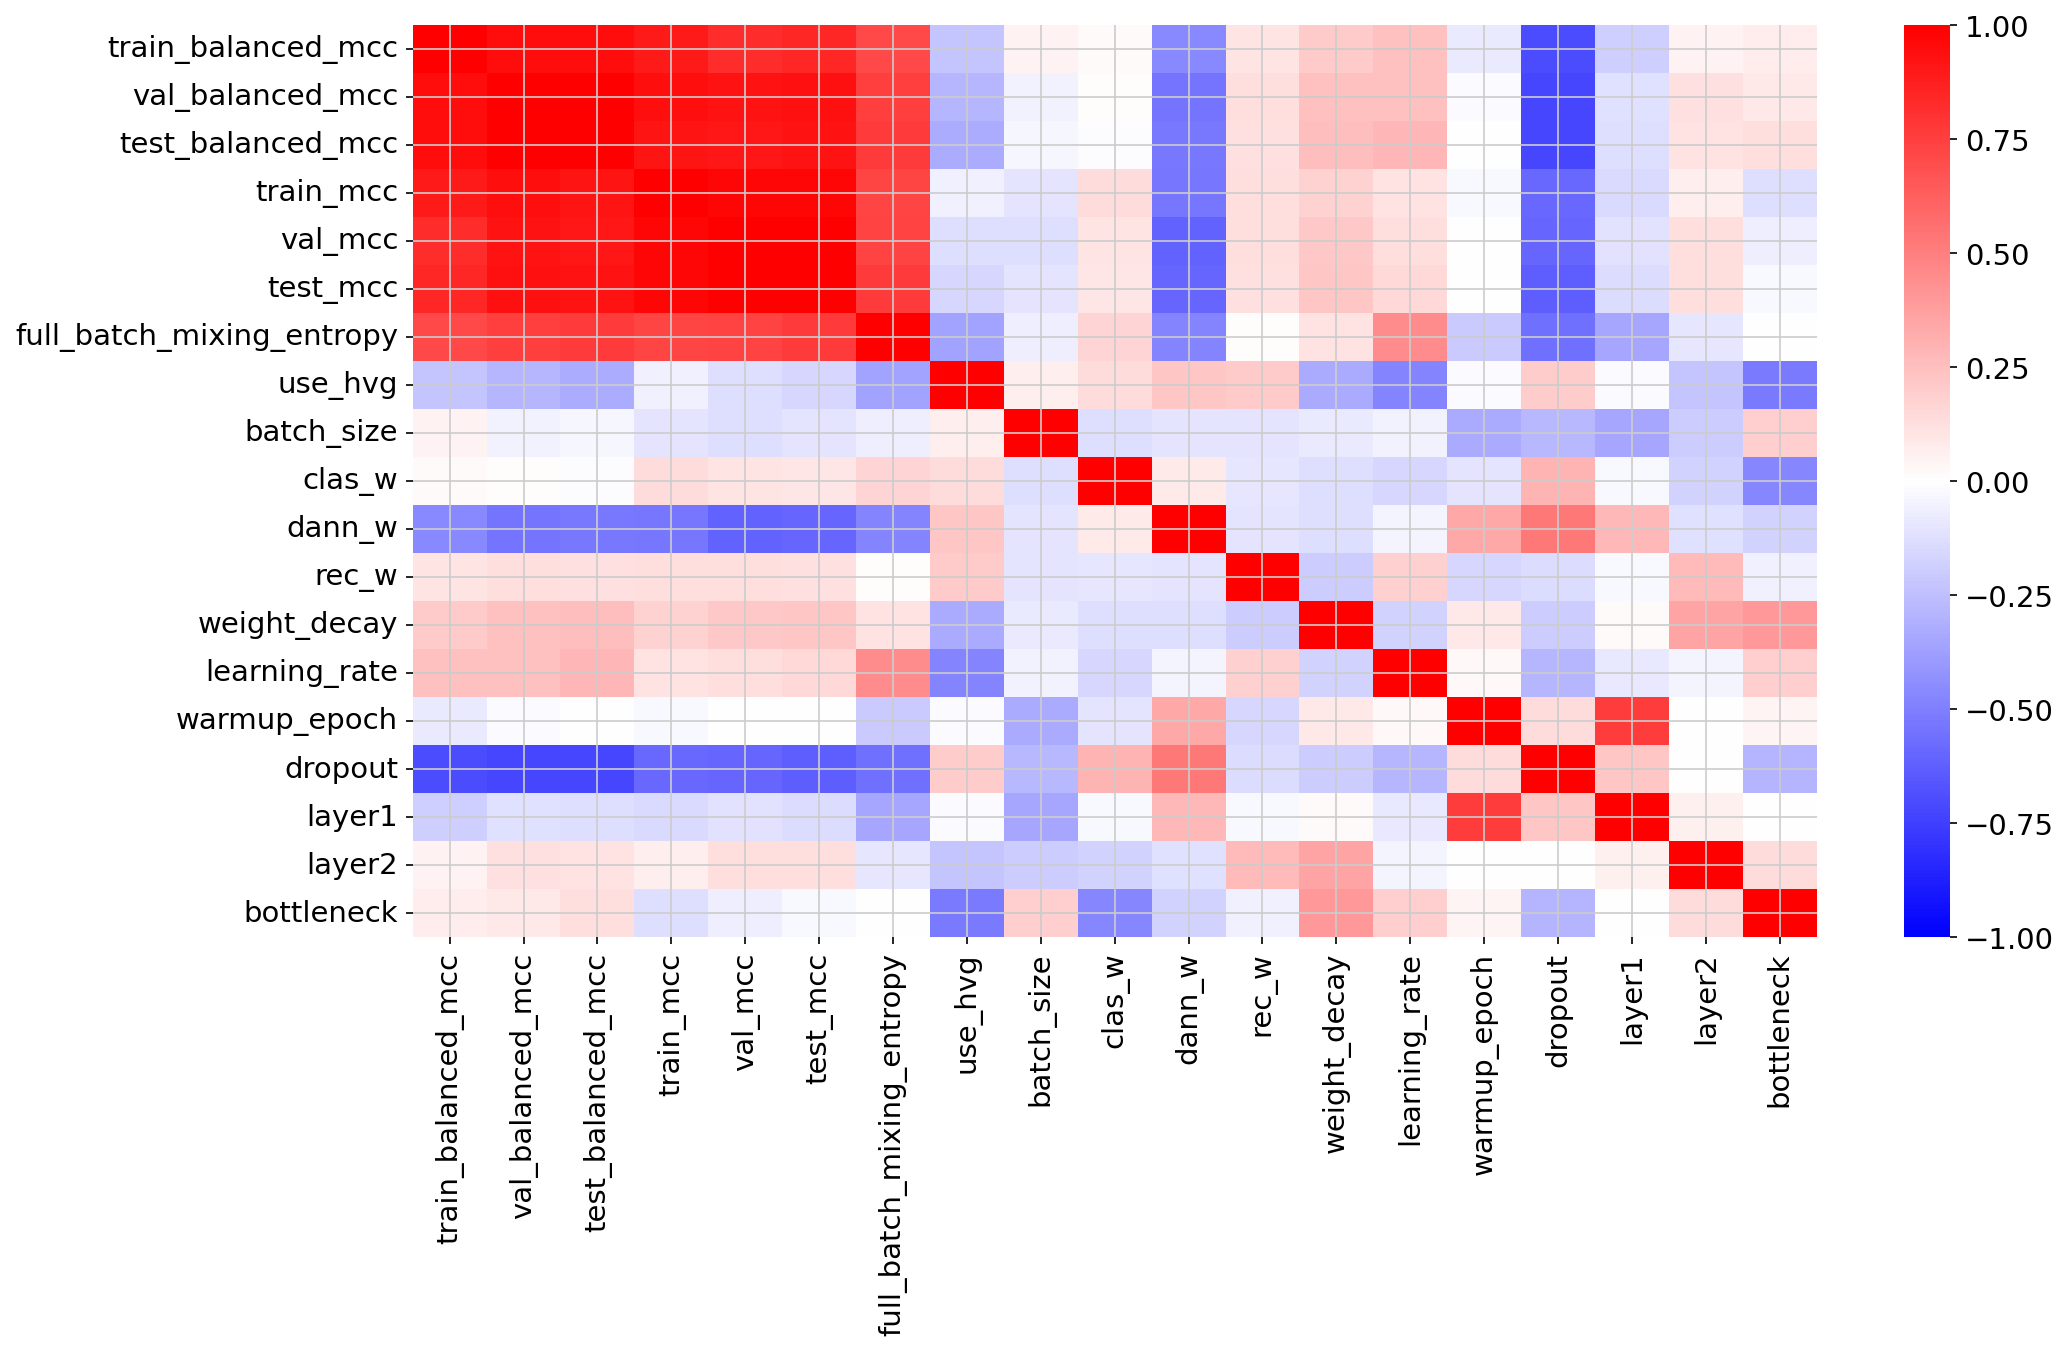

In [311]:
sc.set_figure_params(dpi=75, figsize=(15,8))

sns.heatmap(plot_df.corr(method='pearson'), cmap = 'bwr', vmin = -1, vmax = 1)

In [339]:
a = load_json('/home/acollin/scPermut/experiment_script/benchmark/hp_test_obs.json')

In [341]:
set(a['htap']) == set(['PRC16', 'PRC5', 'PRC7'])

True